In [1]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 125.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


In [ ]:
# 1. INSTALL LIBRARIES
!pip install soundata transformers librosa scikit-learn torch

# 2. IMPORTS & SETUP
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import soundata
import os
import random
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, confusion_matrix, roc_auc_score
from transformers import ASTFeatureExtractor, ASTForAudioClassification
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# Set Device & Seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seeds()

# 3. DOWNLOAD & PREPARE DATASET
print('Initializing UrbanSound8K Dataset')
urbansound8k = soundata.initialize('urbansound8k')
if not os.path.exists(urbansound8k.data_home):
    print('Downloading Dataset')
    urbansound8k.download()
    urbansound8k.validate()

# Create Metadata DataFrame
clip_ids = urbansound8k.clip_ids
metadata_list = []
for clip_id in clip_ids:
    clip = urbansound8k.clip(clip_id)
    metadata_list.append({
        'slice_file_name': clip_id,
        'fold': clip.fold,
        'class': clip.tags.labels[0] if clip.tags.labels else 'unknown',
    })
metadata = pd.DataFrame(metadata_list)
print(f"Dataset Ready: {len(metadata)} samples")

# 4. HELPER CLASSES
class ModelEvaluator:
    def __init__(self, class_names):
        self.class_names = class_names

    def compute_metrics(self, y_true, y_pred, y_proba=None):
        metrics = {}
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
        metrics['precision'] = p
        metrics['recall'] = r
        metrics['f1_score'] = f1
        metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
        return metrics

def aggregate_metrics(fold_metrics):
    avg_metrics = {}
    for metric in ['accuracy', 'f1_score', 'mcc']:
        values = [fm[metric] for fm in fold_metrics]
        avg_metrics[f'{metric}_mean'] = np.mean(values)
        avg_metrics[f'{metric}_std'] = np.std(values)
    return avg_metrics

def print_average_metrics(avg_metrics):
    print(f"Accuracy: {avg_metrics['accuracy_mean']:.4f} (+/- {avg_metrics['accuracy_std']:.4f})")
    print(f"F1 Score: {avg_metrics['f1_score_mean']:.4f}")

# 5. PRE-PROCESS DATA FOR AST
print("\nPre-computing AST inputs (Corrected to 1024 frames)")

# 1. Initialize Extractor with 1024 length (Matches the pre-trained model)
feature_extractor = ASTFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    max_length=1024,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

inputs = []
labels = []

# 2. Loop through dataset
# We perform the same extraction, but now it will pad the 4s audio with silence
# to reach the required 10.24s length.
for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    clip = urbansound8k.clip(row['slice_file_name'])
    y, sr = clip.audio

    # Resample
    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)

    # Extract
    encoded = feature_extractor(y, sampling_rate=16000, return_tensors="pt")
    inputs.append(encoded['input_values'])
    labels.append(row['class'])

# 3. Stack and Move to GPU
# Note: The resulting tensor will be larger now.
X_ast = torch.cat(inputs, dim=0)
print(f"\nCorrected AST Input Shape: {X_ast.shape}") # Should be [8732, 1024, 128]

le = LabelEncoder()
y_ast_numpy = le.fit_transform(labels)
y_ast = torch.tensor(y_ast_numpy, dtype=torch.long)

# Try moving to GPU
X_ast = X_ast.to(device)
y_ast = y_ast.to(device)
print("Data moved to GPU!")

# 6. TRAINING FUNCTION (AST)
def cross_validate_ast(metadata, X_all, y_all, epochs=5, batch_size=16):
    print(f'\nStarting AST Cross Validation...')

    label_encoder = LabelEncoder()
    label_encoder.fit(metadata['class'])
    class_names = label_encoder.classes_
    evaluator = ModelEvaluator(class_names)
    scaler = GradScaler()
    fold_metrics = []

    for fold in range(1, 11):
        print(f'Fold {fold}...', end=' ')

        # Slicing
        train_idx = torch.tensor(metadata[metadata['fold'] != fold].index.values)
        test_idx = torch.tensor(metadata[metadata['fold'] == fold].index.values)

        # Handle GPU vs CPU tensor location
        if X_all.is_cuda:
            X_train, y_train = X_all[train_idx], y_all[train_idx]
            X_test, y_test = X_all[test_idx], y_all[test_idx]
        else:
            X_train, y_train = X_all[train_idx], y_all[train_idx]
            X_test, y_test = X_all[test_idx], y_all[test_idx]

        # Initialize Pre-trained Model
        model = ASTForAudioClassification.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593",
            num_labels=len(class_names),
            ignore_mismatched_sizes=True
        ).to(device)

        # Low LR for fine-tuning
        optimizer = optim.AdamW(model.parameters(), lr=1e-5)
        criterion = nn.CrossEntropyLoss()

        # Train Loop (Manual Batching)
        model.train()
        num_samples = X_train.shape[0]

        for epoch in range(epochs):
            perm = torch.randperm(num_samples, device=device if X_train.is_cuda else 'cpu')
            for i in range(0, num_samples, batch_size):
                indices = perm[i : i + batch_size]

                batch_X = X_train[indices]
                batch_y = y_train[indices]

                # Move to GPU if strictly needed
                if not batch_X.is_cuda:
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)

                optimizer.zero_grad()
                with autocast():
                    outputs = model(batch_X).logits
                    loss = criterion(outputs, batch_y)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        # Eval Loop
        model.eval()
        with torch.no_grad():
            y_pred = []
            y_test_cpu = []

            for i in range(0, X_test.shape[0], batch_size):
                batch_X = X_test[i : i + batch_size]
                if not batch_X.is_cuda:
                    batch_X = batch_X.to(device)

                outputs = model(batch_X).logits
                preds = torch.max(outputs, 1)[1]
                y_pred.extend(preds.cpu().numpy())

            y_test_cpu = y_test.cpu().numpy()

        metrics = evaluator.compute_metrics(np.array(y_test_cpu), np.array(y_pred))
        fold_metrics.append(metrics)
        print(f"Acc: {metrics['accuracy']:.4f}")

    avg_metrics = aggregate_metrics(fold_metrics)
    print_average_metrics(avg_metrics)
    return fold_metrics, avg_metrics

# 7. RUN IT
results = {}
ast_fold, ast_avg = cross_validate_ast(metadata, X_ast, y_ast, epochs=5, batch_size=32)
results['AST'] = ast_avg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 37.0 MB/s eta 0:00:00
Using Device: cuda
Initializing UrbanSound8K Dataset


5.61GB [1:22:36, 1.22MB/s]                           
1.15MB [00:01, 689kB/s]                            
100%|██████████| 8732/8732 [00:16<00:00, 541.70it/s]


Dataset Ready: 8732 samples

Pre-computing AST inputs (Corrected to 1024 frames)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

100%|██████████| 8732/8732 [01:51<00:00, 78.63it/s] 



Corrected AST Input Shape: torch.Size([8732, 1024, 128])
Data moved to GPU!

Starting AST Cross Validation...
Fold 1... 

/tmp/ipython-input-1280785001.py:135: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8809
Fold 2... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8908
Fold 3... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.7946
Fold 4... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8788
Fold 5... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.9316
Fold 6... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.9016
Fold 7... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8890
Fold 8... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8685
Fold 9... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.9216
Fold 10... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1280785001.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8984
Accuracy: 0.8856 (+/- 0.0354)
F1 Score: 0.8827


In [11]:
train_idx = torch.tensor(metadata[metadata['fold'] != 10].index.values)
test_idx = torch.tensor(metadata[metadata['fold'] == 10].index.values)

X_train, y_train = X_ast[train_idx], y_ast[train_idx]
X_test, y_test = X_ast[test_idx], y_ast[test_idx]

label_encoder = LabelEncoder()
label_encoder.fit(metadata['class'])
class_names = label_encoder.classes_

model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=len(class_names),
    ignore_mismatched_sizes=True
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
epochs = 5
batch_size = 32

# 4. Train Loop
model.train()
num_samples = X_train.shape[0]

print(f"Training on {num_samples} samples (Folds 1-9)")

for epoch in range(epochs):
    perm = torch.randperm(num_samples, device=device if X_train.is_cuda else 'cpu')
    total_loss = 0

    # Progress bar for sanity
    pbar = tqdm(range(0, num_samples, batch_size), desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    for i in pbar:
        indices = perm[i : i + batch_size]
        batch_X = X_train[indices]
        batch_y = y_train[indices]

        if not batch_X.is_cuda:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(batch_X).logits
            loss = criterion(outputs, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss/((i/batch_size)+1))

Restoring Fold 10 Model state...


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3635795897.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training on 7895 samples (Folds 1-9)...


Epoch 1/5:   0%|          | 0/247 [00:00<?, ?batch/s]/tmp/ipython-input-3635795897.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/5: 100%|██████████| 247/247 [00:50<00:00,  4.86batch/s, loss=0.00712]

Model Restored. Ready for Visualization.


1. Preparing Data & Running Inference Done.


/tmp/ipython-input-3928967193.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Class', data=acc_df, palette='viridis', ax=ax4)


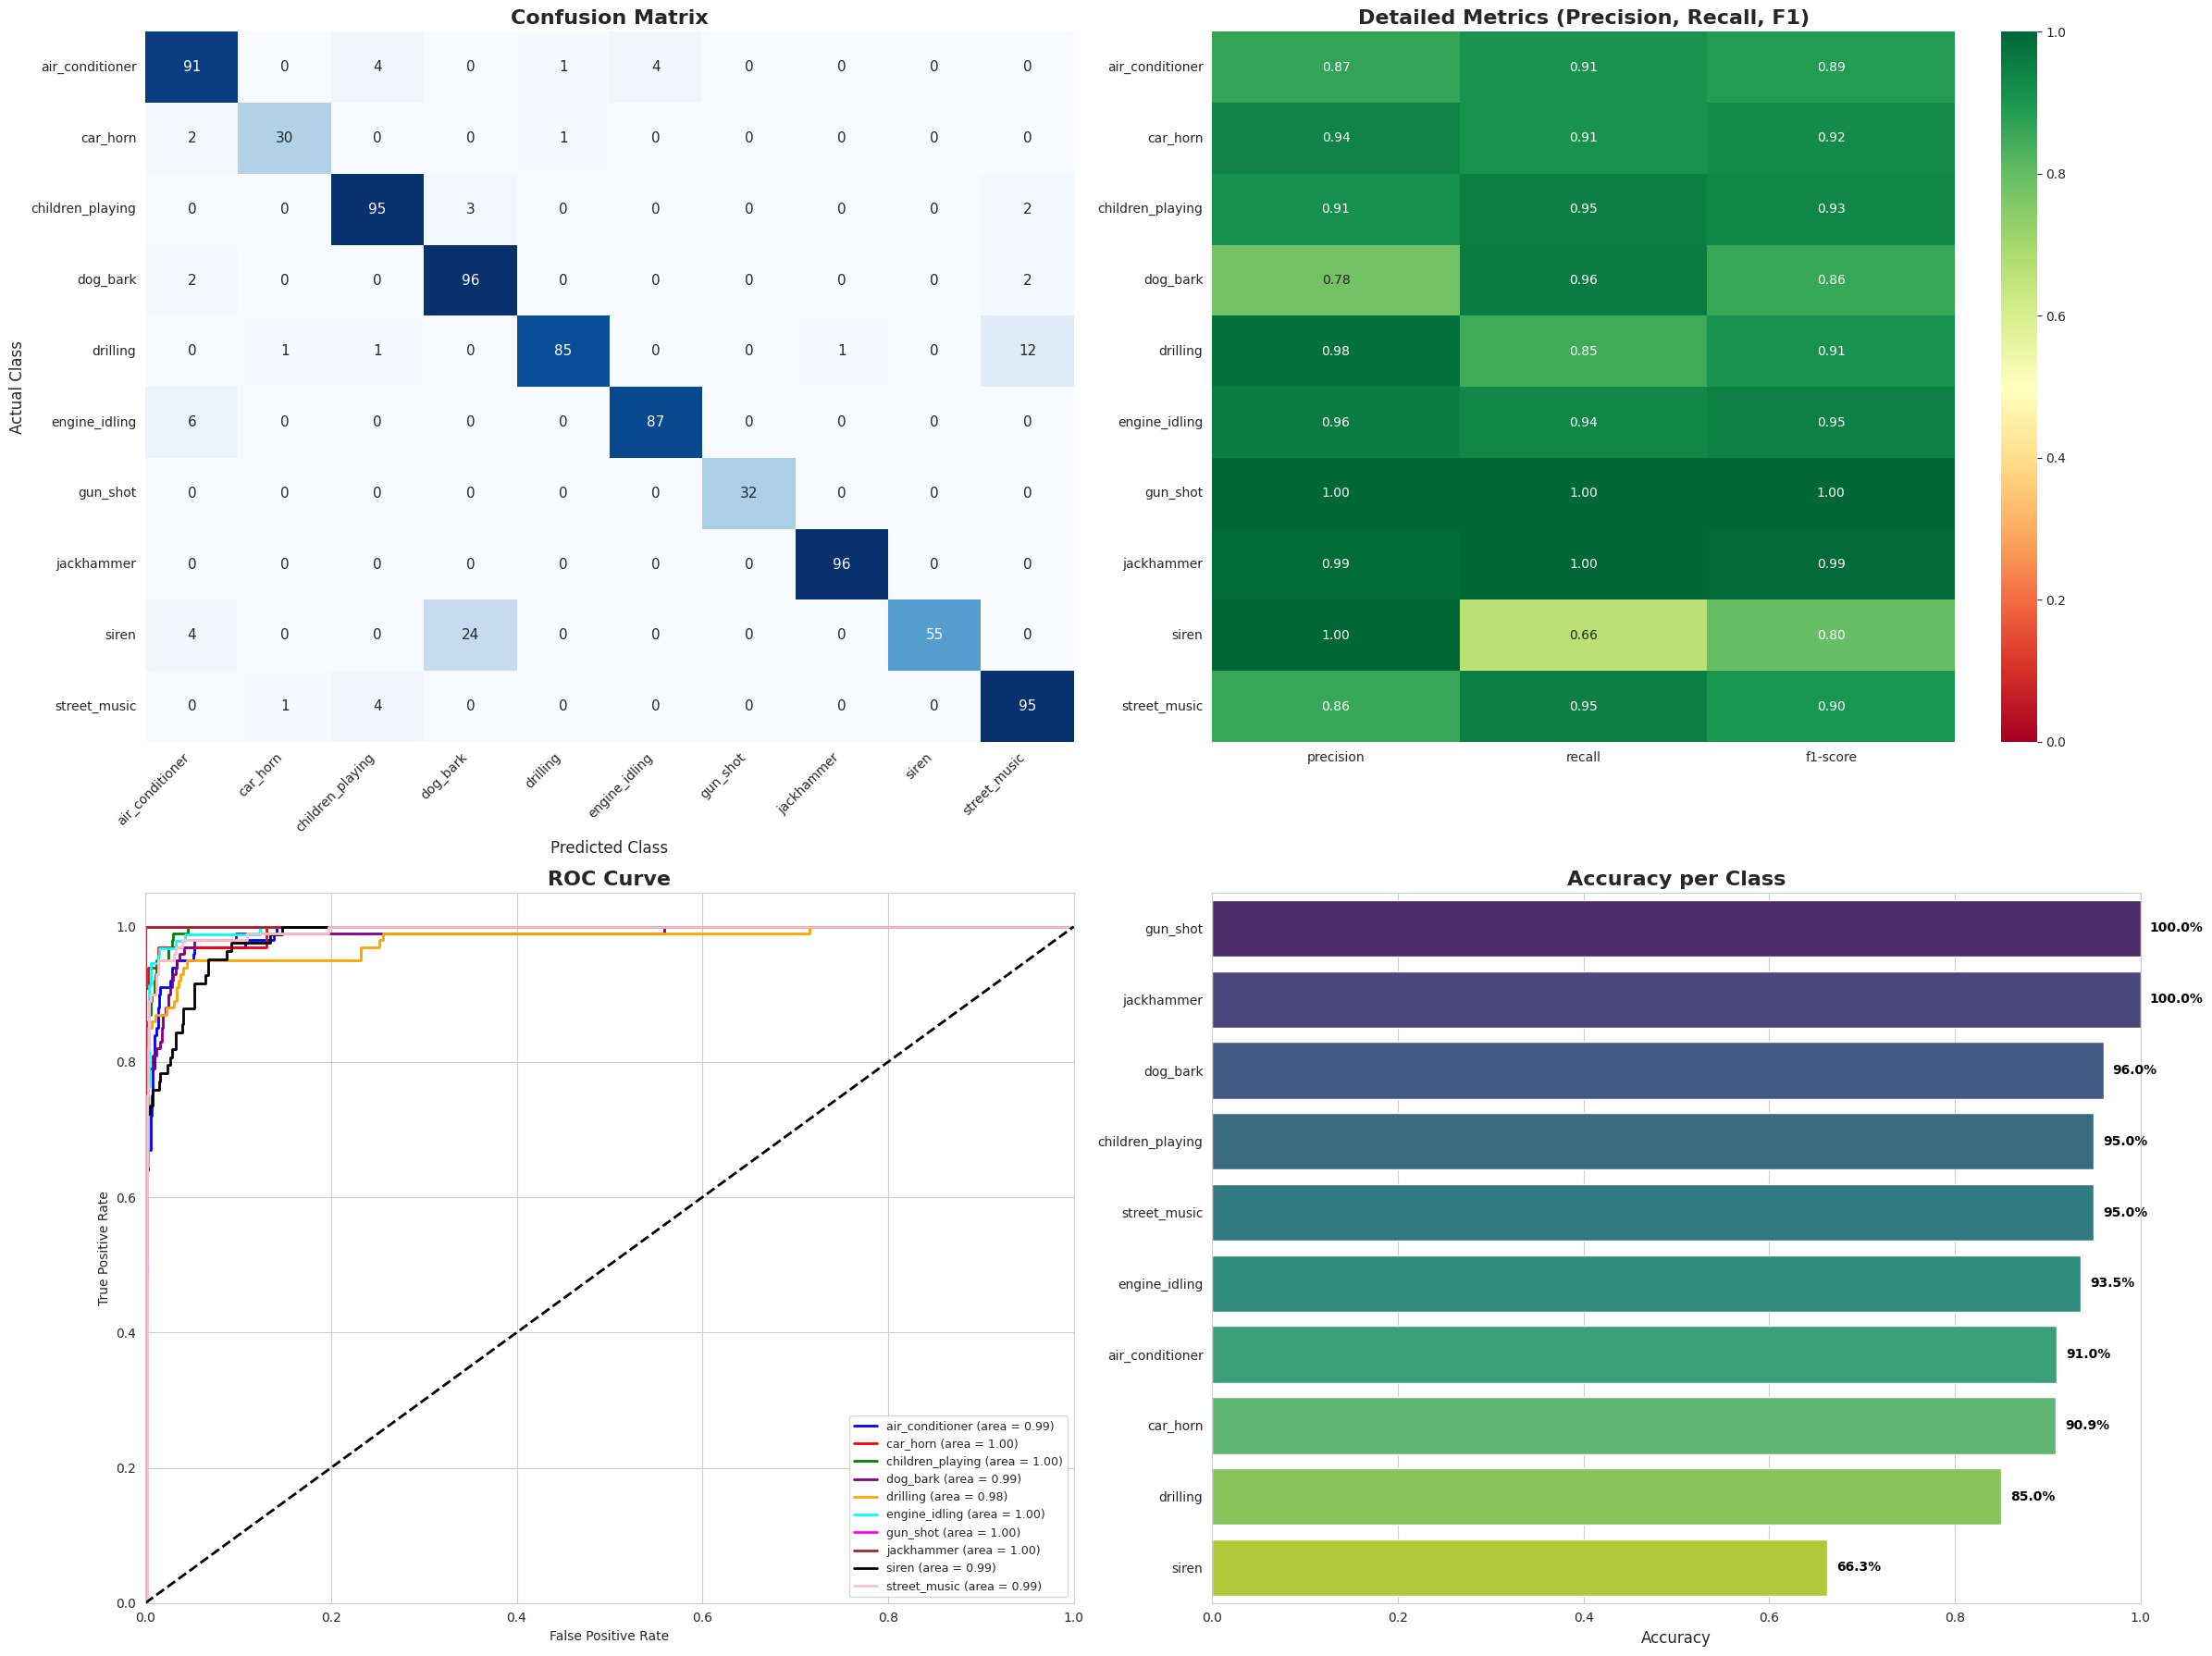


Overall Test Accuracy: 91.04%


In [14]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from numpy import interp
from itertools import cycle

# 1. SETUP & INFERENCE (FOLD 10)
print("1. Preparing Data & Running Inference", end=" ")

# A. Setup Labels
le = LabelEncoder()
le.fit(metadata['class'])
class_names = le.classes_
n_classes = len(class_names)

# B. Slice Fold 10 Data
test_idx = torch.tensor(metadata[metadata['fold'] == 10].index.values)
X_test_viz = X_ast[test_idx]
y_test_viz = y_ast[test_idx]

# C. Inference Loop
model.eval()
y_preds = []
y_probs = [] # Need probabilities for ROC
y_true = y_test_viz.cpu().numpy()
batch_size = 32

with torch.no_grad():
    for i in range(0, X_test_viz.shape[0], batch_size):
        batch_X = X_test_viz[i : i + batch_size]
        if not batch_X.is_cuda:
            batch_X = batch_X.to(device)

        outputs = model(batch_X).logits

        # Get Predictions (Class Index)
        preds = torch.max(outputs, 1)[1]
        y_preds.extend(preds.cpu().numpy())

        # Get Probabilities (Softmax)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs.extend(probs.cpu().numpy())

y_probs = np.array(y_probs)
print("Done.")

# 2. GENERATE PLOTS
sns.set_style("whitegrid")
fig = plt.figure(figsize=(24, 18)) # Huge canvas

# --- PLOT A: CONFUSION MATRIX ---
ax1 = plt.subplot(2, 2, 1)
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, ax=ax1, annot_kws={"size": 11})
ax1.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
ax1.set_ylabel('Actual Class', fontsize=12)
ax1.set_xlabel('Predicted Class', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# --- PLOT B: CLASSIFICATION REPORT HEATMAP ---
ax2 = plt.subplot(2, 2, 2)
clf_report = classification_report(y_true, y_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(clf_report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap="RdYlGn", fmt=".2f", vmin=0.0, vmax=1.0, ax=ax2)
ax2.set_title('Detailed Metrics (Precision, Recall, F1)', fontsize=16, fontweight='bold')
ax2.set_yticks(np.arange(len(report_df))+0.5)
ax2.set_yticklabels(report_df.index, rotation=0)

# --- PLOT C: MULTI-CLASS ROC CURVE ---
ax3 = plt.subplot(2, 2, 3)
# Binarize labels for ROC
y_test_bin = label_binarize(y_true, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'black', 'pink'])
for i, color in zip(range(n_classes), colors):
    ax3.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

ax3.plot([0, 1], [0, 1], 'k--', lw=2)
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve', fontsize=16, fontweight='bold')
ax3.legend(loc="lower right", fontsize=9)

# --- PLOT D: CLASS-WISE ACCURACY BAR CHART ---
ax4 = plt.subplot(2, 2, 4)
# Calculate accuracy per class manually from Confusion Matrix
class_accuracies = cm.diagonal() / cm.sum(axis=1)
# Create DataFrame for plotting
acc_df = pd.DataFrame({'Class': class_names, 'Accuracy': class_accuracies})
acc_df = acc_df.sort_values('Accuracy', ascending=False)

sns.barplot(x='Accuracy', y='Class', data=acc_df, palette='viridis', ax=ax4)
ax4.set_xlim(0, 1.0)
ax4.set_title('Accuracy per Class', fontsize=16, fontweight='bold')
ax4.set_xlabel('Accuracy', fontsize=12)
ax4.set_ylabel('')

# Add percentage labels
for i, v in enumerate(acc_df['Accuracy']):
    ax4.text(v + 0.01, i, f"{v*100:.1f}%", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nOverall Test Accuracy: {np.mean(y_true == y_preds)*100:.2f}%")